# FLIM Workflow Example

This notebook show an example of how to automate the phasor plot generation and clustering in order to achieve a segmentation result based on lifetime differences.



In [1]:
import napari
import hdbscan
import pandas as pd
import napari_flim_phasor_plotter as flim_plot

from napari.utils import nbscreenshot
from skimage.measure import label, regionprops_table

Below are the parameters used in this workflow.

In [2]:
# phasor plot parameters
manual_threshold = 15
harmonic = 1
apply_median_filter = True
median_filter_iterations = 1

# hdbscan parameters
hdbscan_min_cluster_size = 40
hdbscan_min_samples = 40

# post-processing parameters
chosen_cluster_label = 20
fill_area_threshold = 100
smooth_radius = 3

## Open sample data in napari

Open napari viewer by running the cell below.

In [3]:
viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


And open a FLIM sample image (alternatively go to File -> Open Sample -> napari-flim-phasor-plotter -> Seminal Receptacle)

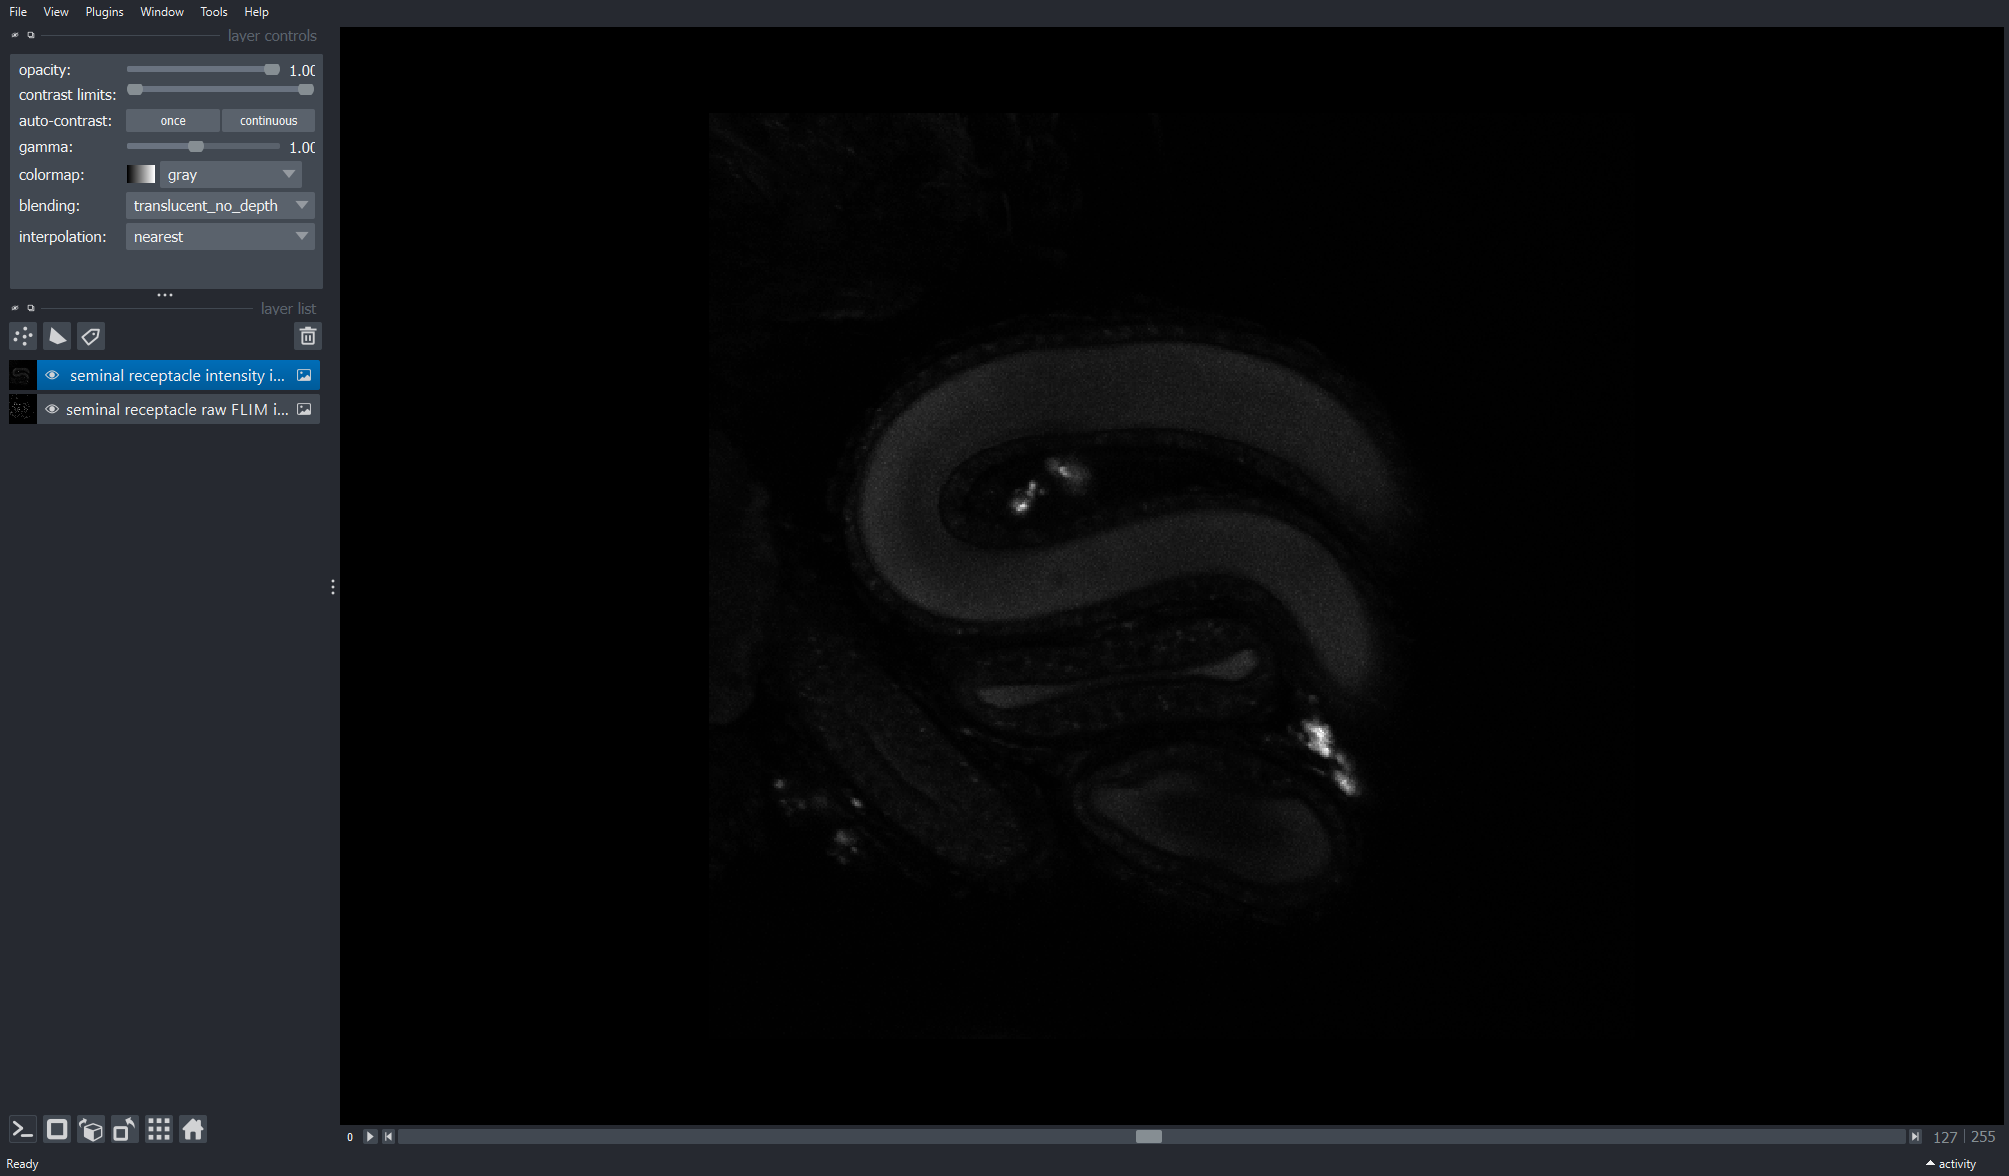

In [4]:
layer_raw_FLIM_image, layer_image = viewer.open_sample(plugin='napari-flim-phasor-plotter', sample='receptacle')
nbscreenshot(viewer)

## Make the phasor plot

Below we make a phasor plot from the raw FLIM image and display it in napari (alternatively go to Plugins -> napari-flim-phasor-plotter -> Calculate Phasors).

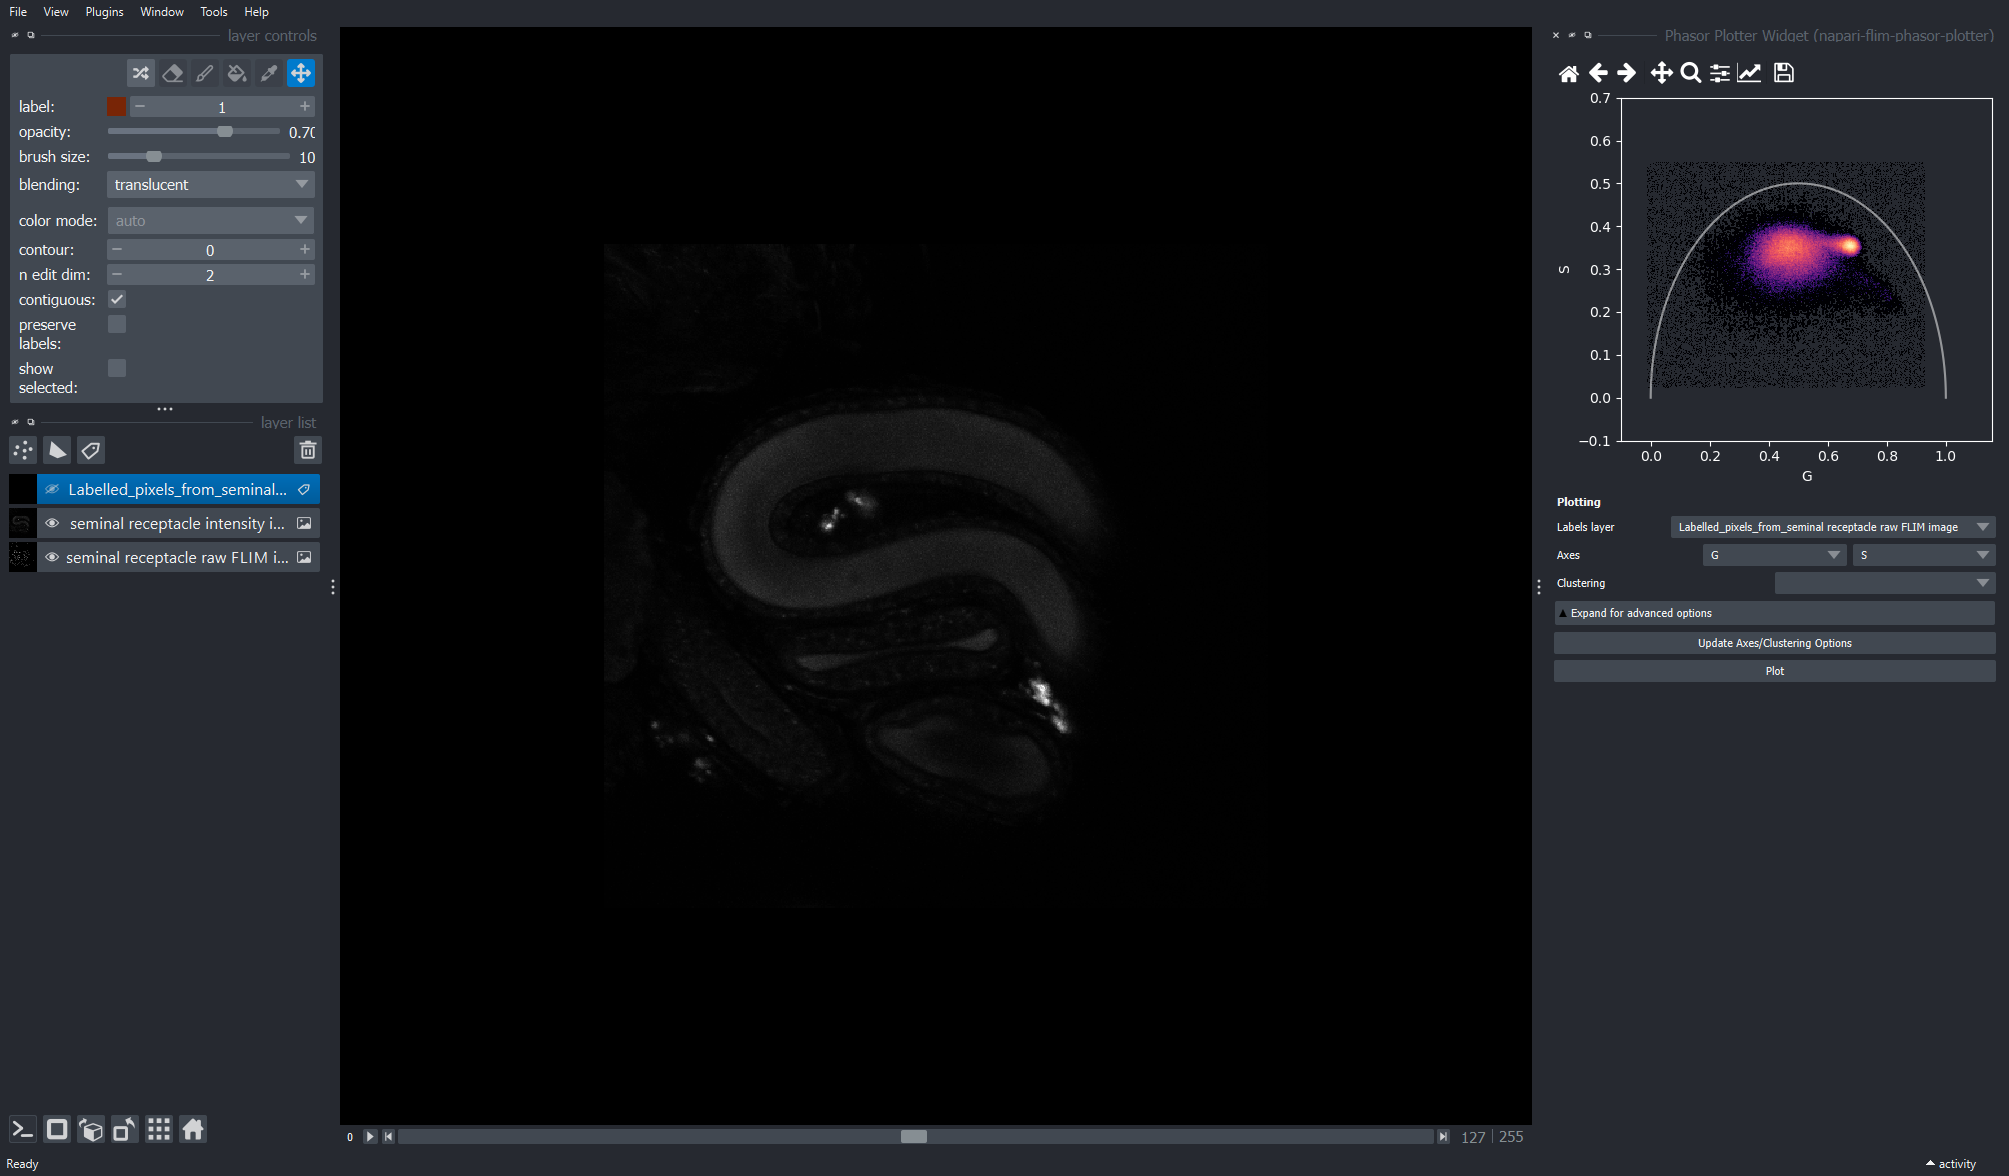

In [5]:
# Get widget instance
plot_maker_widget = flim_plot._widget.make_flim_phasor_plot()
# Run plot maker widget
phasor_plot_widget, labels_layer = plot_maker_widget(
        image_layer=layer_raw_FLIM_image,
        threshold = manual_threshold,
        apply_median = apply_median_filter,
        median_n = median_filter_iterations,
        napari_viewer = viewer)
nbscreenshot(viewer)

Set color scaling to logarithm for a better visualization of all the points (also possible under 'Expand for advanced options').

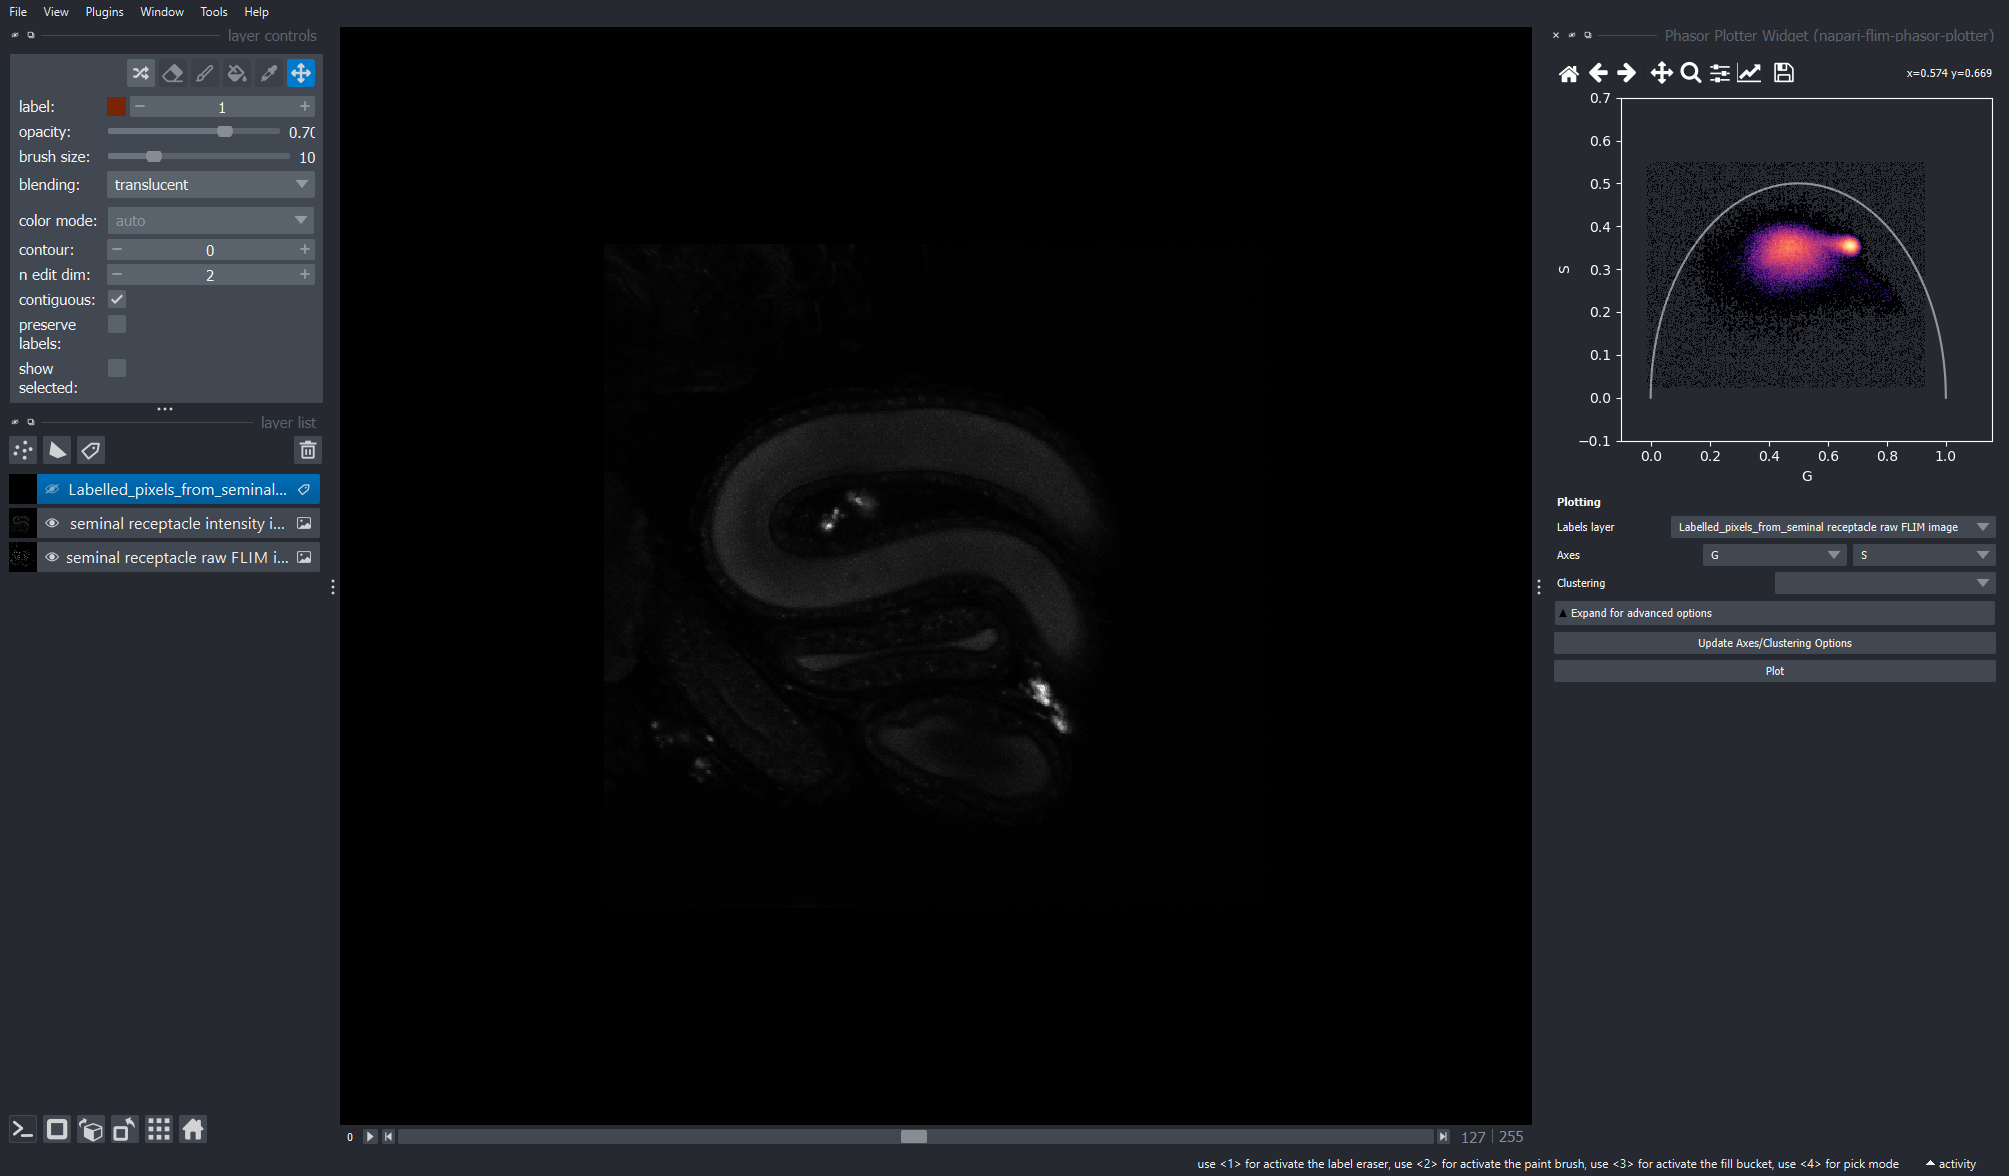

In [6]:
phasor_plot_widget.log_scale.setChecked(True)
nbscreenshot(viewer)

Now, we get the features table from the recently created labels layer.

In [7]:
features_table = labels_layer.features
features_table


label         G         S  frame
0            1  0.368575  0.378603      0
1            2  0.368575  0.379517      0
2            3  0.333649  0.379517      0
3            4  0.360470  0.362263      0
4            5  0.360470  0.362263      0
...        ...       ...       ...    ...
123724  123725  0.399062  0.289760      0
123725  123726  0.399062  0.286353      0
123726  123727  0.167012  0.289760      0
123727  123728  0.251258  0.329581      0
123728  123729  0.361668  0.355341      0

[123729 rows x 4 columns]

## Cluster 'G' and 'S' (with HDBSCAN)

Here we use HDBSCAN to automatically find clusters and update the features table with the prediction results. Manual cluster selection could also be used in napari.

Alternatively, run Clustering on 'G' and 'S' with napari-clusters-plotter (Tools -> Measurement post-processing -> Clustering). Check [napari-clusters-plotter repository](https://github.com/BiAPoL/napari-clusters-plotter#clustering) for more details.

In [8]:
clustering_hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=hdbscan_min_cluster_size,
    min_samples=hdbscan_min_samples,
)
# Run clustering on G and S coordinates
hdbscan_predictions = clustering_hdbscan.fit_predict(features_table[['G', 'S']])
clustering_id = "HDBSCAN_CLUSTER_ID"

We add HDBSCAN predictions to table.

In [9]:
features_table[clustering_id] = hdbscan_predictions
features_table

label         G         S  frame  HDBSCAN_CLUSTER_ID
0            1  0.368575  0.378603      0                  -1
1            2  0.368575  0.379517      0                  -1
2            3  0.333649  0.379517      0                  -1
3            4  0.360470  0.362263      0                  -1
4            5  0.360470  0.362263      0                  -1
...        ...       ...       ...    ...                 ...
123724  123725  0.399062  0.289760      0                  -1
123725  123726  0.399062  0.286353      0                  -1
123726  123727  0.167012  0.289760      0                  -1
123727  123728  0.251258  0.329581      0                  -1
123728  123729  0.361668  0.355341      0                  -1

[123729 rows x 5 columns]

And we update the layer features with the table as well as the plotter clustering options.

In [10]:
# update layer features table
labels_layer.features = features_table
# update clustering id list
phasor_plot_widget.update_axes_and_clustering_id_lists()
# set clustering id in dropdown
phasor_plot_widget.plot_cluster_id.setCurrentText(clustering_id)

Finally, we display clusters predictions on the phasor plot and the corresponding pixels as a new Labels layer.

c:\Users\mazo260d\mambaforge\envs\napari-flim-dev\lib\site-packages\napari\components\viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,


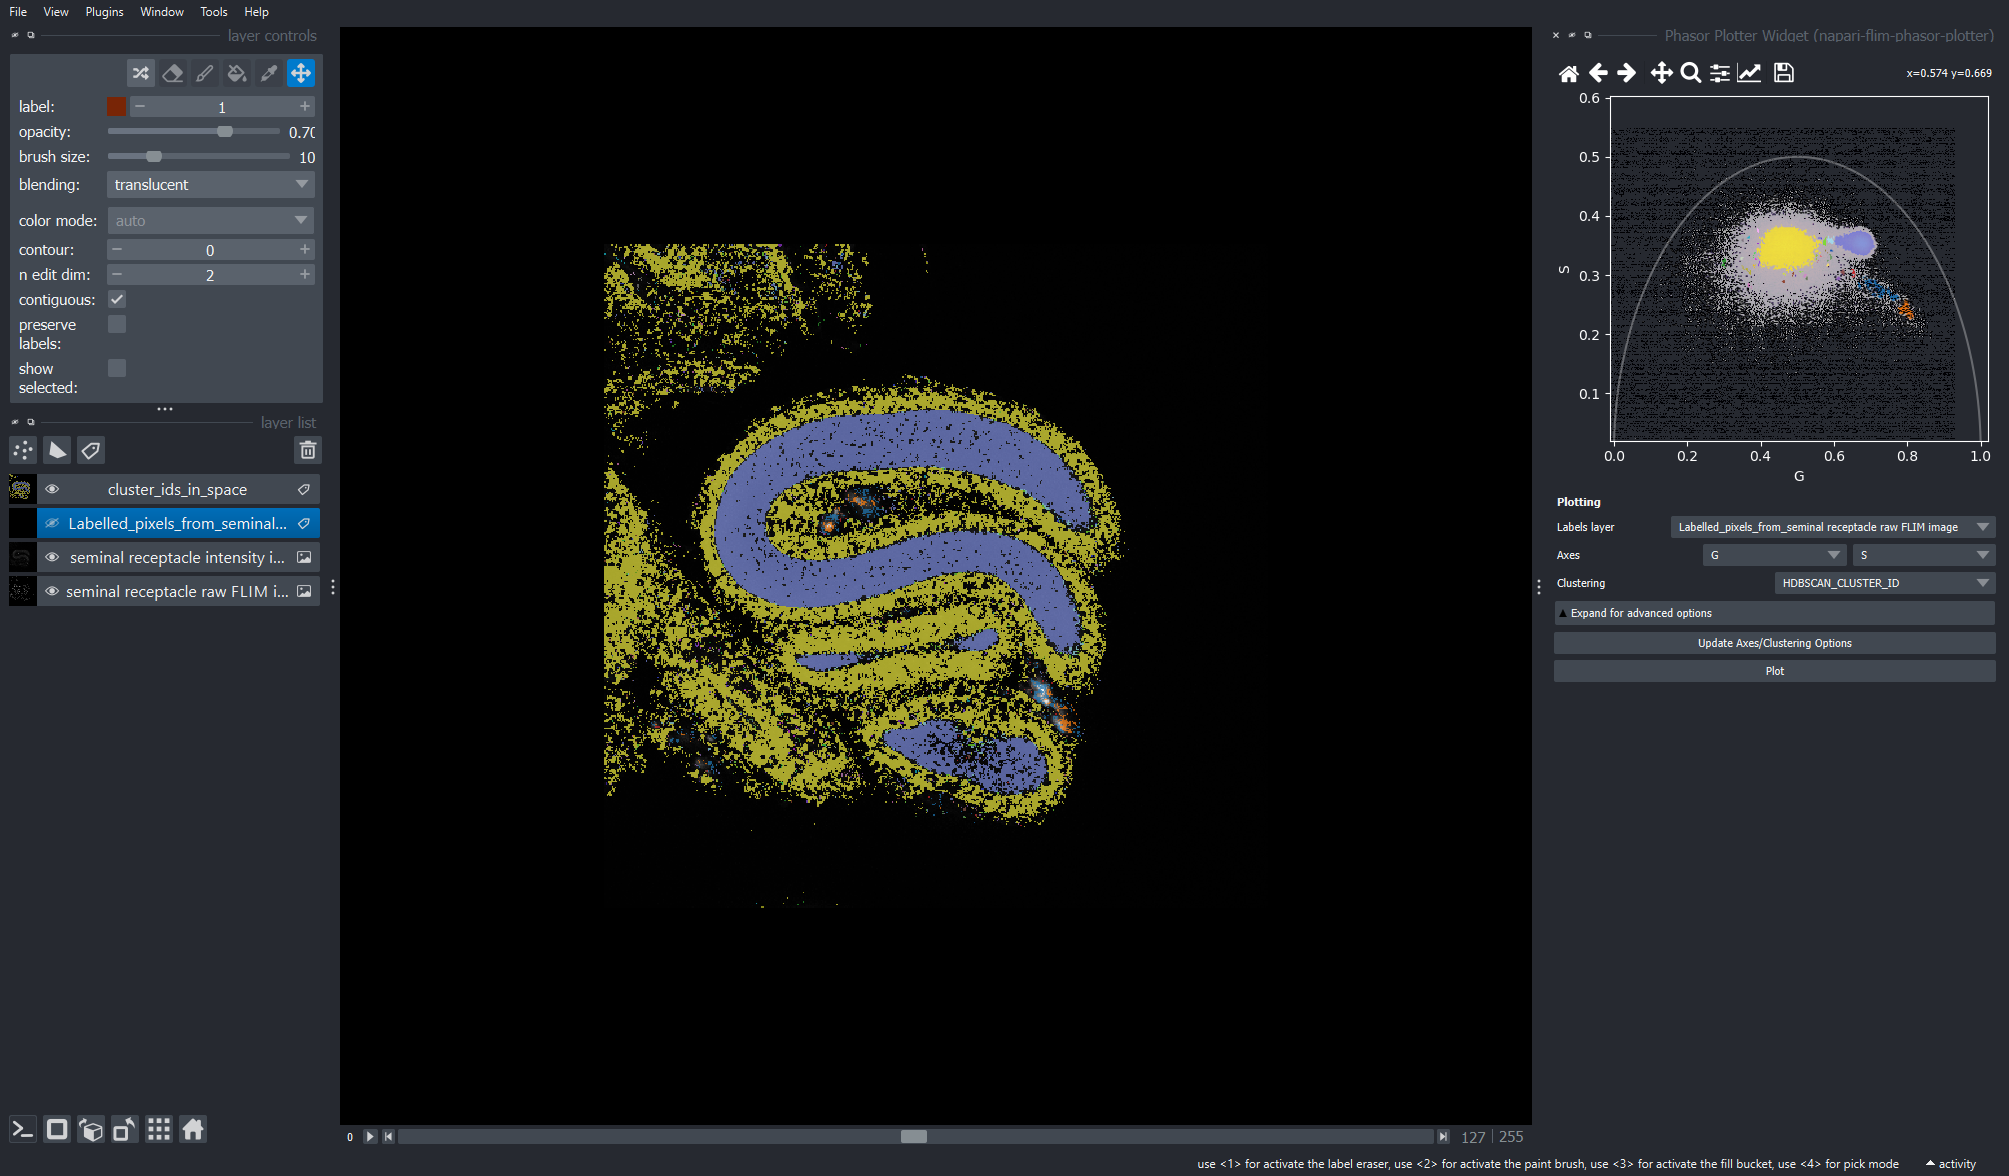

In [11]:
phasor_plot_widget.run(
    labels_layer.features,
    phasor_plot_widget.plot_x_axis.currentText(),
    phasor_plot_widget.plot_y_axis.currentText(),
    phasor_plot_widget.plot_cluster_id.currentText(),)
# Get clusters labels layer
clusters_labels_layer = phasor_plot_widget.visualized_labels_layer
nbscreenshot(viewer)

## Post-Processing
###  Extract chosen label

From the clusters, we could choose one (or more) cluster of interest to further process segmentation results.

We use the `manual_label_extract` function for that.

Alternatively, use Plugins -> napari-flim-phasor-plotter -> Manual Label Extraction

C:\Users\mazo260d\Documents\GitHub\napari-flim-phasor-plotter\src\napari_flim_phasor_plotter\_widget.py:233: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please use Labels.colormap.color_dict instead. Note: thiswill only work when the colormap is a DirectLabelsColormap.
  label_color = cluster_labels_layer.color


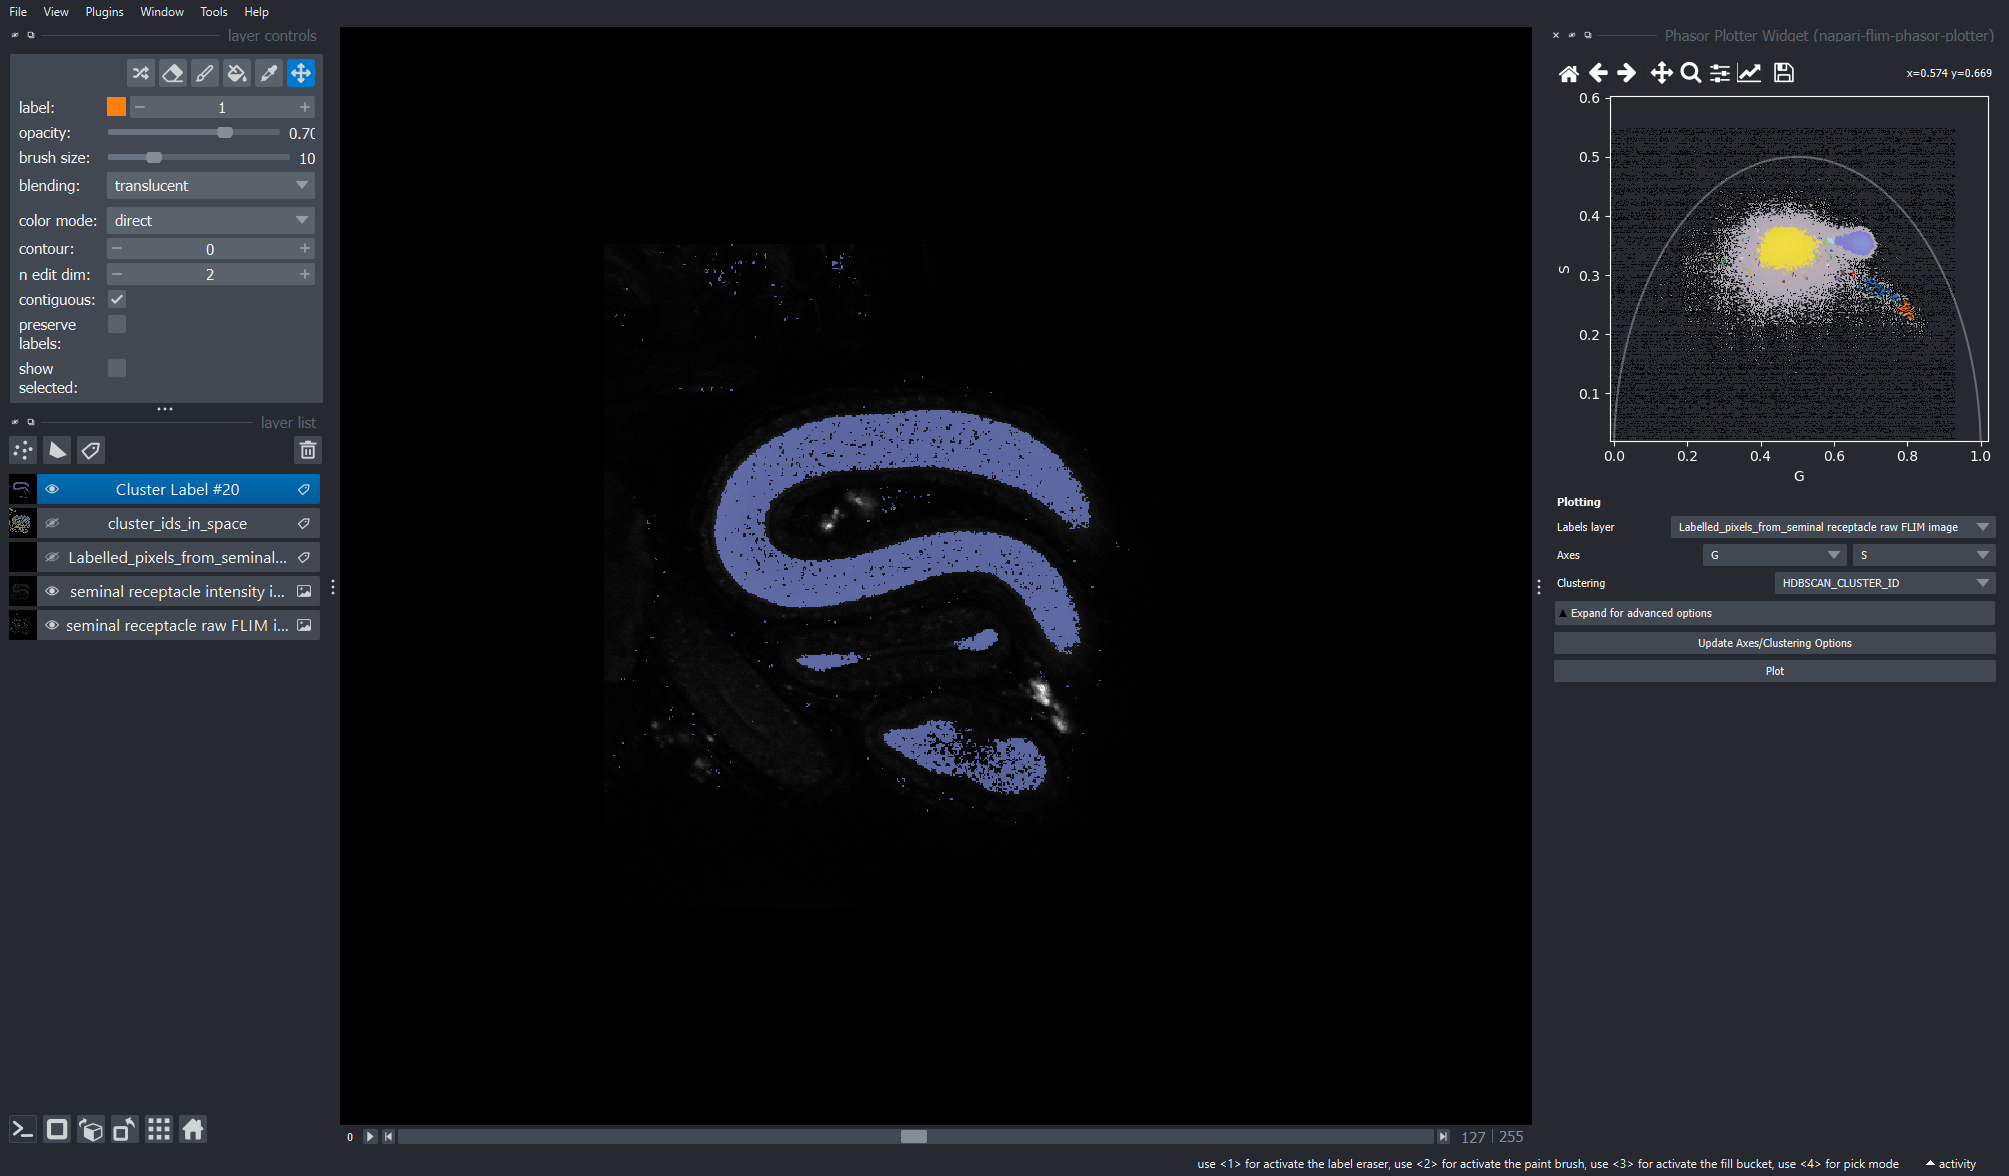

In [12]:
extraced_labels_layer = flim_plot._widget.manual_label_extract(clusters_labels_layer, chosen_cluster_label)
viewer.layers[-1].visible = False
viewer.add_layer(extraced_labels_layer)
nbscreenshot(viewer)

Optionally we can add the n largest cluster labels to napari as individual layers with `split_n_largest_cluster_labels` (also available via Plugins -> napari-flim-phasor-plotter -> Split N Largest Clusters Labels).

In [13]:
list_of_labels_layers = flim_plot._widget.split_n_largest_cluster_labels(
    labels_layer=labels_layer,
    clusters_labels_layer=clusters_labels_layer,
    clustering_id=clustering_id,
    n=5,
)
# Uncomment code below to add layers to viewer
# for layer in list_of_labels_layers:
#     viewer.add_layer(layer)


C:\Users\mazo260d\Documents\GitHub\napari-flim-phasor-plotter\src\napari_flim_phasor_plotter\_widget.py:233: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please use Labels.colormap.color_dict instead. Note: thiswill only work when the colormap is a DirectLabelsColormap.
  label_color = cluster_labels_layer.color
C:\Users\mazo260d\Documents\GitHub\napari-flim-phasor-plotter\src\napari_flim_phasor_plotter\_widget.py:233: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please use Labels.colormap.color_dict instead. Note: thiswill only work when the colormap is a DirectLabelsColormap.
  label_color = cluster_labels_layer.color
C:\Users\mazo260d\Documents\GitHub\napari-flim-phasor-plotter\src\napari_flim_phasor_plotter\_widget.py:233: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please use Labels.colormap.color_dict instead. Note: thiswill only work when the colormap is a Dir

### Smooth chosen cluster mask

Different morphological post-processing could be applied. We provide a general smoothing function in the plugin called `smooth_cluster_mask`.

Alternatively, use Plugins -> napari-flim-phasor-plotter -> Smooth Cluster Mask.

C:\Users\mazo260d\Documents\GitHub\napari-flim-phasor-plotter\src\napari_flim_phasor_plotter\_widget.py:419: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please use Labels.colormap.color_dict instead. Note: thiswill only work when the colormap is a DirectLabelsColormap.
  label_color = cluster_mask_layer.color


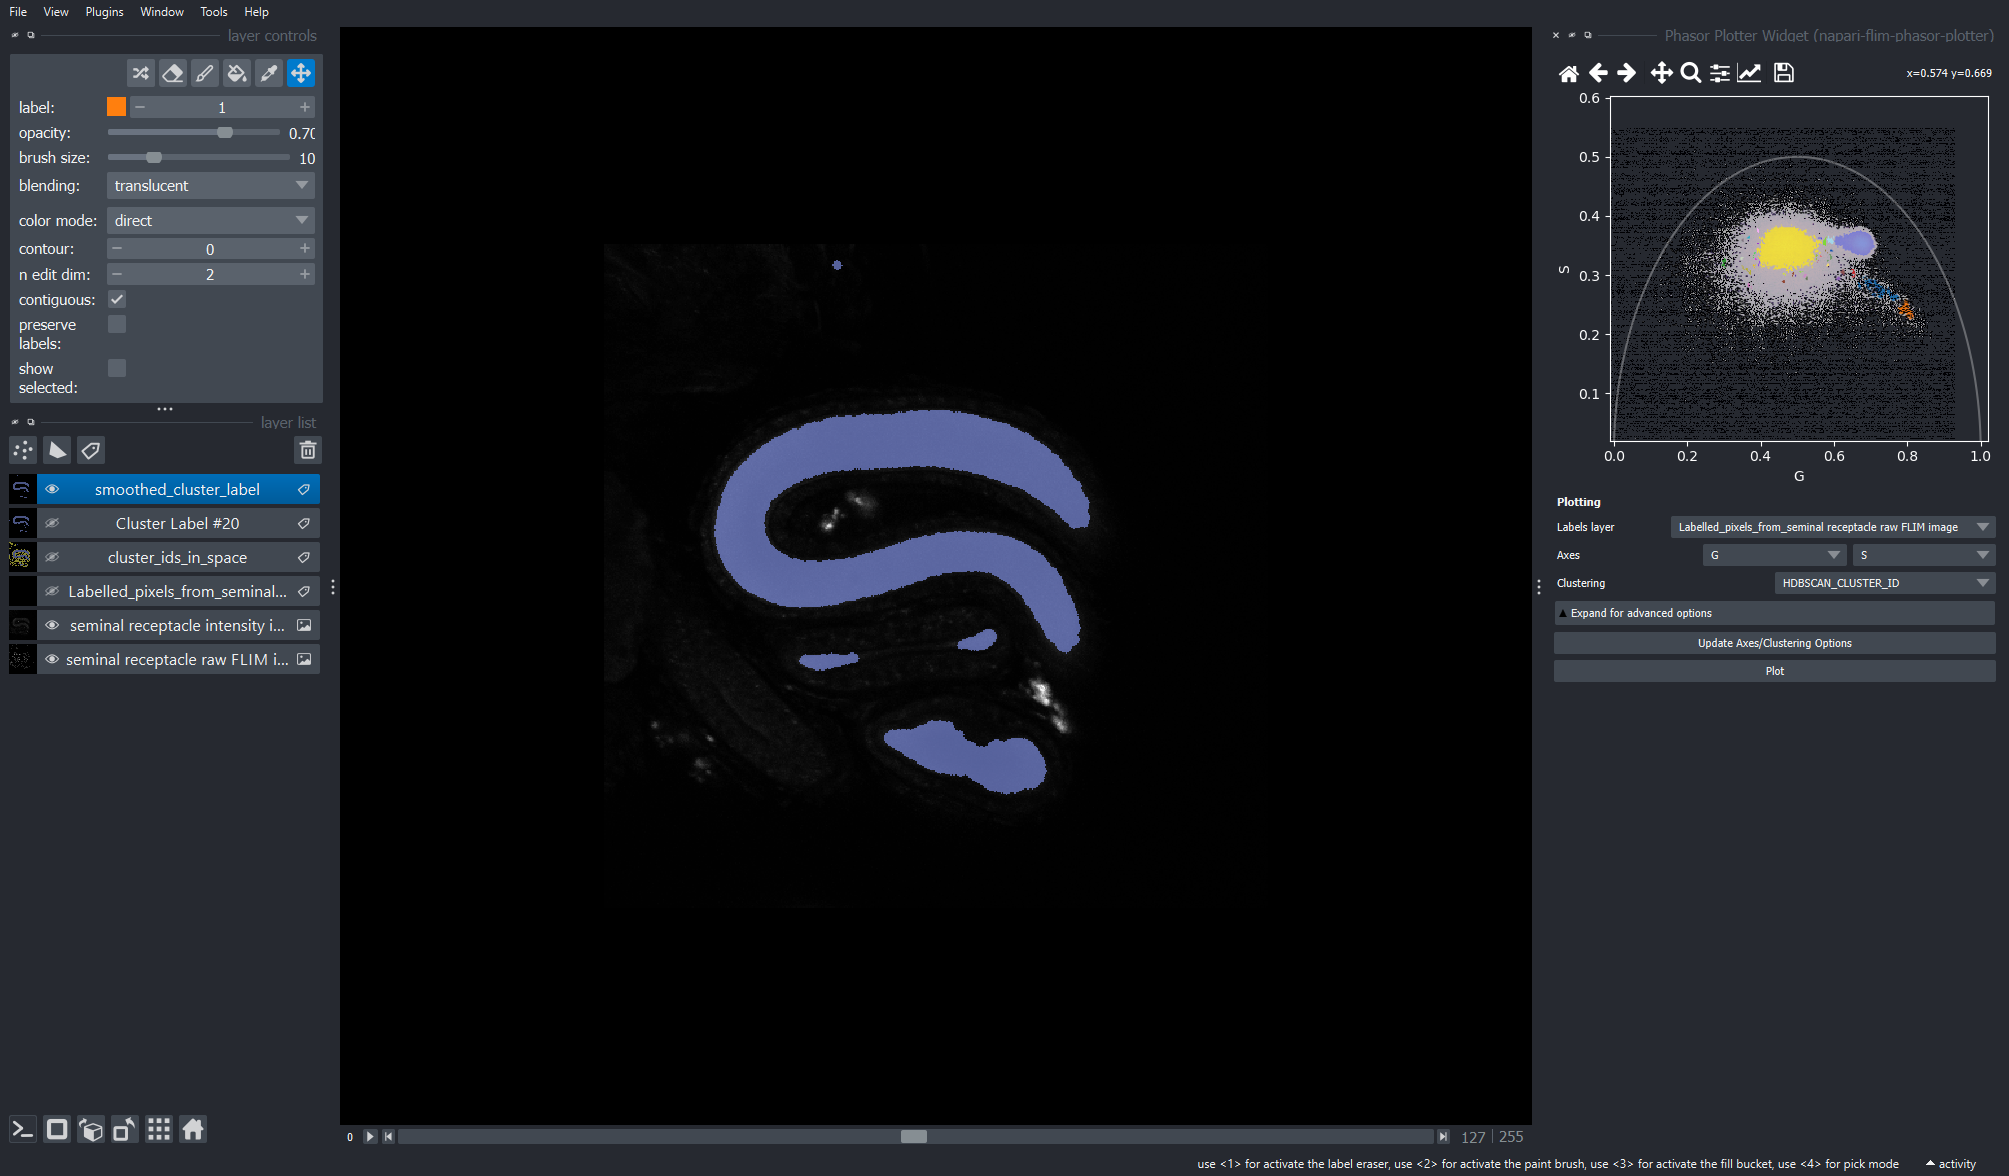

In [14]:
smoothed_cluster_label = flim_plot._widget.smooth_cluster_mask(
    cluster_mask_layer=extraced_labels_layer,
    fill_area_px=fill_area_threshold,
    smooth_radius=smooth_radius,
)
smoothed_cluster_label.name = 'smoothed_cluster_label'
viewer.layers[-1].visible = False
viewer.add_layer(smoothed_cluster_label)
nbscreenshot(viewer)

### Instance Segmentation and Feature Extraction

Now, we perform instance segmentation and feature extraction using scikit-image.
You can optionally: 
- apply connected components labeling with Tools -> Segmentation / Labeling -> Connected component labeling;
- and perform features extraction with Tools -> Measurement Tables -> Object Features/Properties.



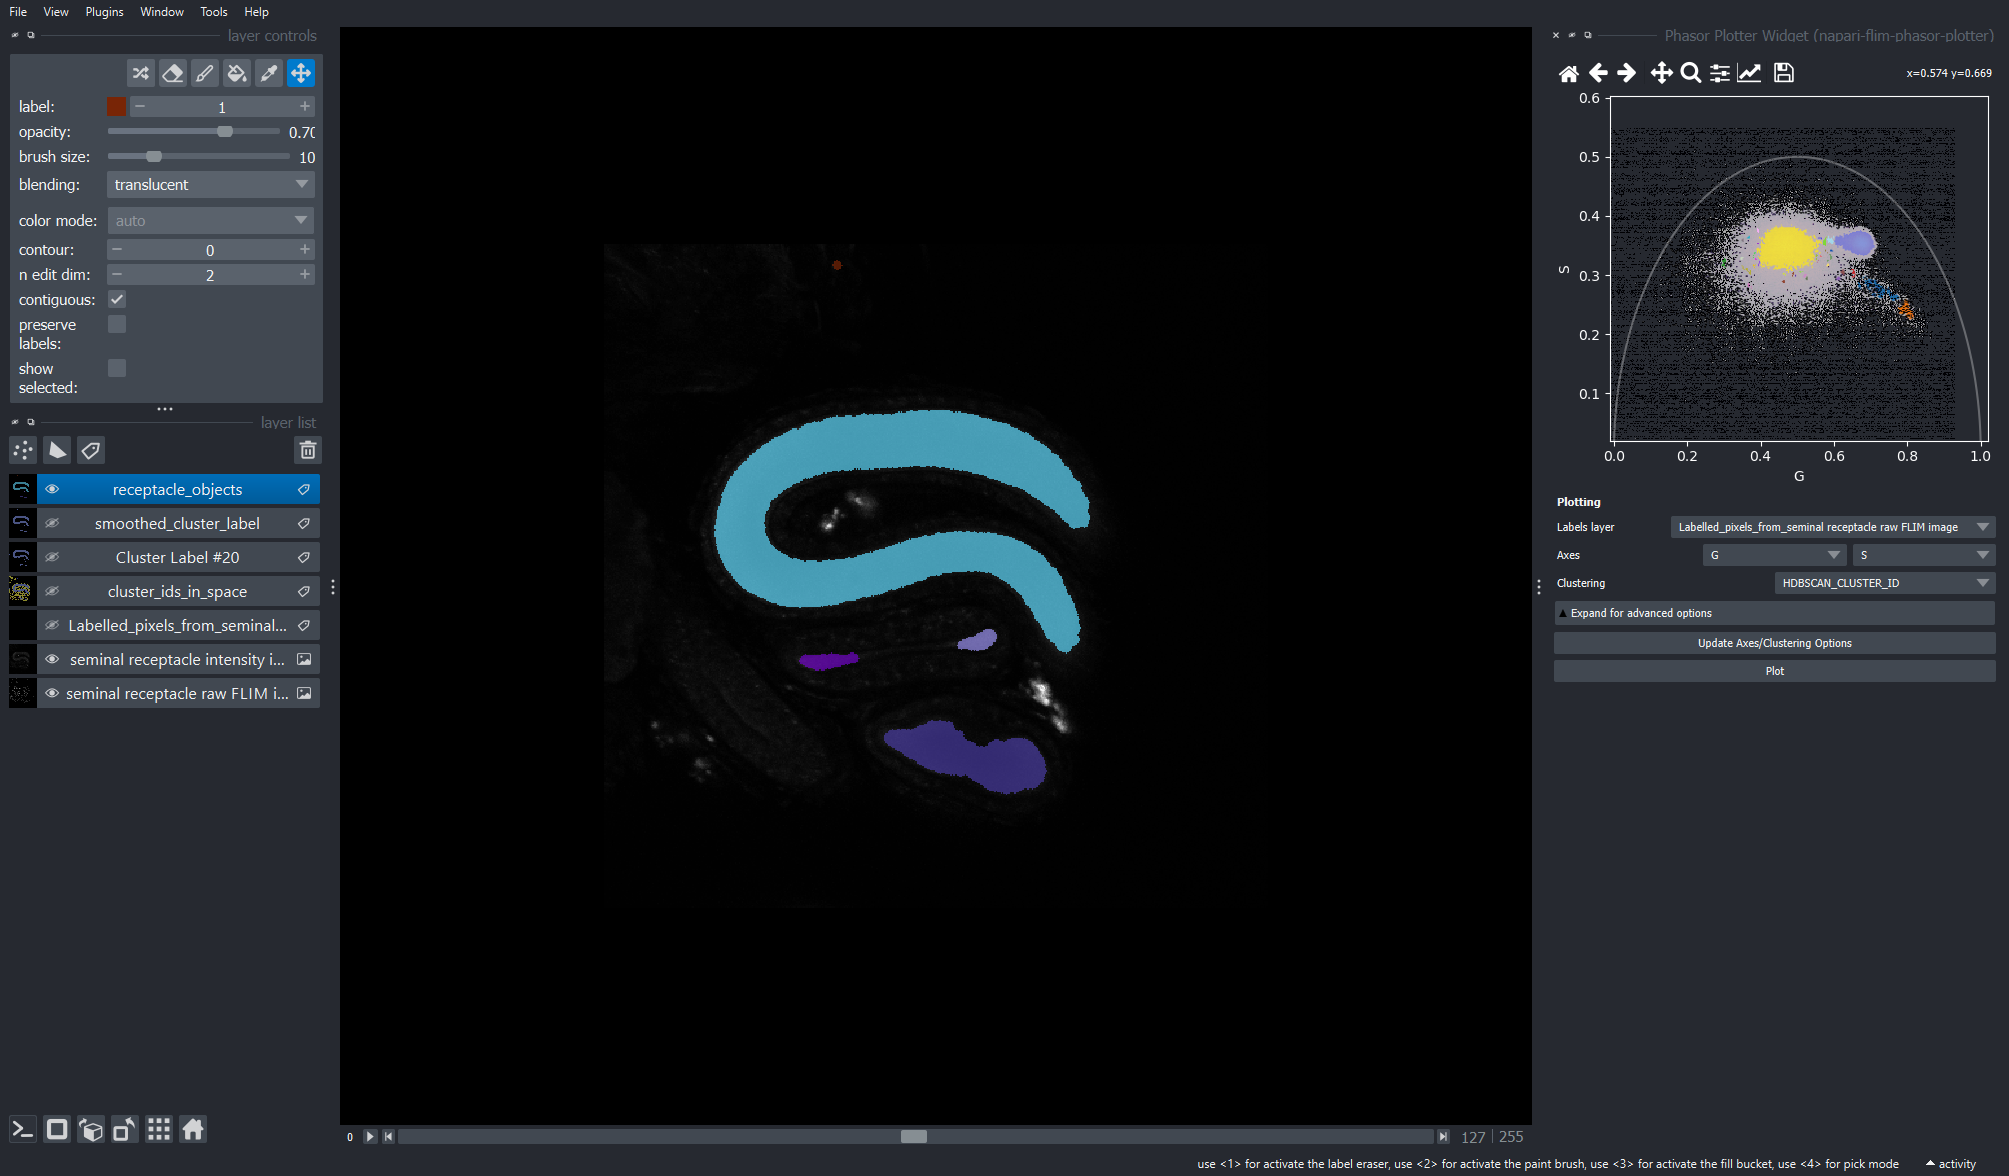

In [15]:
objects_labels = label(smoothed_cluster_label.data)
features_table = pd.DataFrame(regionprops_table(label_image = objects_labels, properties = ['label', 'area']))
viewer.layers[-1].visible = False
viewer.add_labels(objects_labels, features = features_table, name = 'receptacle_objects')
nbscreenshot(viewer)

In [16]:
features_table

label     area
0      1     41.0
1      2  23236.0
2      3    320.0
3      4    431.0
4      5   3963.0

Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342


Optionally, we can display the table in napari with Tools > Measurement > Show Table; Select the 'receptacle objects' layer and click Run.

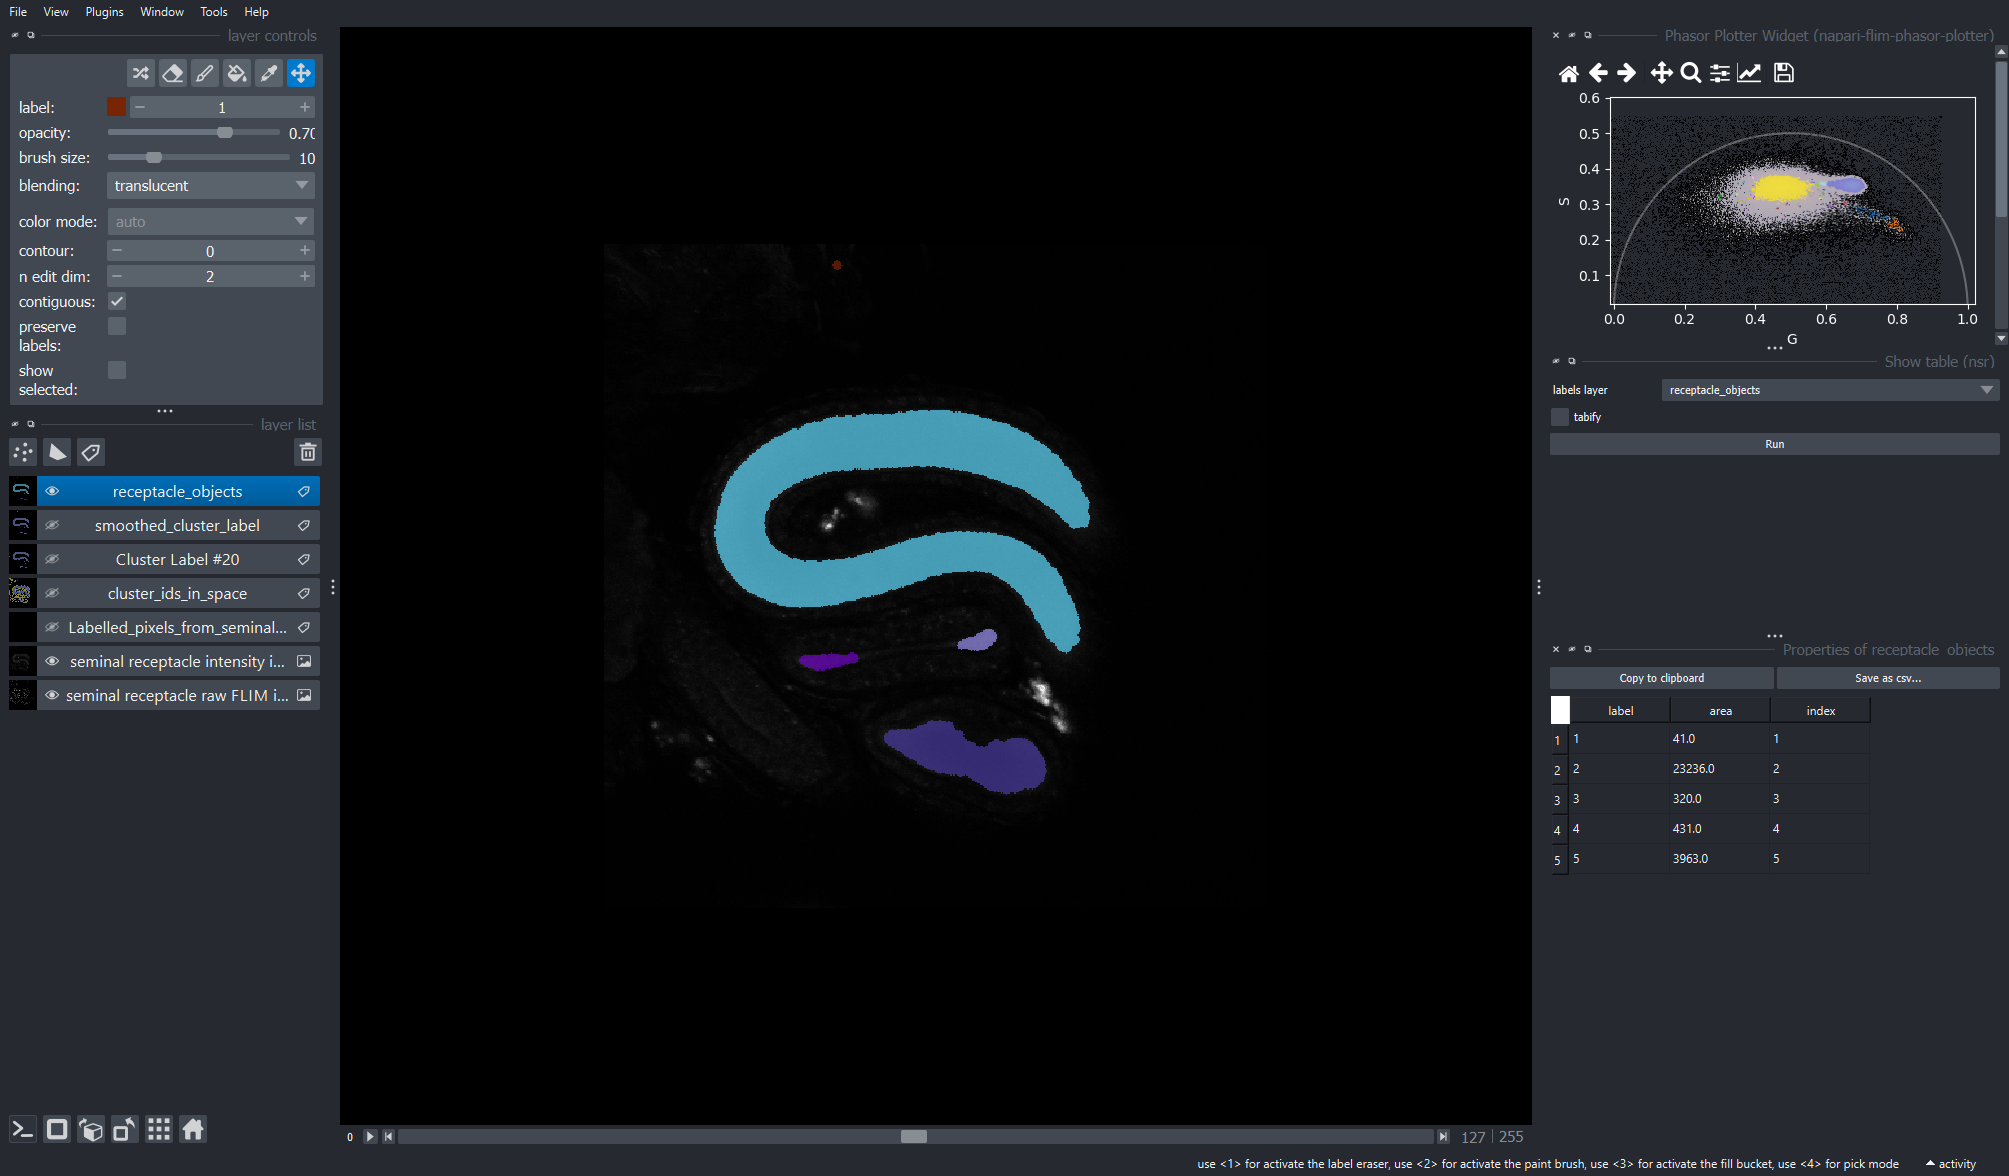

In [17]:
nbscreenshot(viewer)